## Coursera IBM Data Science Capstone Project
### Battle of the Neighborhoods
*Author: Ujwal Raj Sah*  
*May, 2020*

#### Contents
1. [Introduction / Business Problem](#introduction)
2. [Data Preparation](#data-prep)  
    2.1. [Common Data](#id-2-1)  
    2.2. [Province Number 3 Location Data](#id-2-2)  
    2.3. [Province Number 3 Location and Population Data](#id-2-3)  
    2.4. [Province Number 3 Location, Population and Income Data](#id-2-4)  
    2.5. [Province Number 2 Location Data](#id-2-5)  
    2.6. [Province Number 2 Location and Population Data](#id-2-6)  
    2.7. [Province Number 3 Location, Population and Income Data](#id-2-7)
3. [Methodology](#methodology)  
    3.1. [Madrid Neighborhoods Visualization](#id-3-1)  
    3.2. [Explore Madrid Neighborhoods using the Foursquare API](#id-3-2)  
    3.3. [Clustering Madrid and val neighborhoods](#id-3-3)  
    3.4. [Neighborhood Ranking](#id-3-4)
4. [Results Summary](#results)

## 1. Introduction / Business Problem <a id='introduction'></a>
This notebook corresponds to the final assignment of the Coursera *Applied Data Science Capstone* course, which is the final step for the *IBM Data Science Professional Certificate* specialization. The final capstone project consists on applying the methodologies learned during the specialization to solve a fictional business problem, ensuring that the Foursquare API data is used in part of the analysis.  

For this project, I selected to work with selecting a suitable location for a fictional Hotel in Province Number 2 of Nepal. Below is the business problem description:  

Our customer, the hotel chain “XYZ” is interested in opening a new hotel in Province Number 2.
This would be our customer’s second restaurant location, after having successfully opened a venue in Kathmandu a very lively neighborhood from Province Number 3. Considering that our customer has had very good results with their Kathmandu location, they have requested our data science team to find a neighborhood with similar characteristics. The problem question would be: **What neighborhood from Province 2 has the most similar characteristics in terms of Hotel establishment compared to Kathmandu in Province 3?**

The data to be used for this project comes from four different locations:  
* Foursquare. It is a local search-and-discovery service which provides information on different types of entertainment, drinking, living and dining venues. Foursquare has an API that can be used to query their database and find information related to the venues, such as location, overall category, reviews and tips.  
* Province 2 and Province 3 Neighborhood Names and geographic coordinates. Available on https://opendatanepal.com/dataset/nepal-municipalities-wise-geographic-data-shp-geojson-topojson-kml. It was processed outside this notebook to obtain coordinates for Province 2 and Province 3 Neighborhood.
* Province 2 and Province 3 Neighborhood Population Information. Data available on https://opendatanepal.com/dataset/total-population-by-sex-country-province-district-and-local-level
* Province 2 and Province 3 District Income Information. Data available on https://opendatanepal.com/dataset/life-expectancy-income-of-nepal-by-district. I could not find income information at Neighborhood level


## 2. Data Preparation<a id='data-prep'></a>

On this section, we will consolidate the data from our three data sources into a new dataset we will use for the clustering process. 

We will first import all libraries to be used on this section, and then proceed with the data wrangling.

In [232]:
import pandas as pd
import numpy as np
import folium
import requests
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### 2.1. Common Data<a id='id-2-1'></a>

#### Country Population Data

In [142]:
population = pd.read_csv('local-level-population.csv')
population.sample(5)

,NEIGHBORHOOD,GENDER,POPULATION
588,Godawari,female,41521
1086,Dewahi Gonahi,female,15692
336,Dhankuta,female,19597
1495,Chhathar,male,7679
1463,Byas,male,31889


In [143]:
#we only need total population not genderwise population
population_t = population.groupby('NEIGHBORHOOD').sum()
population_t.reset_index(inplace=True)
population_t.head()

,NEIGHBORHOOD,POPULATION
0,Aadarsha,24482
1,Aadarsha Kotwal,27552
2,Aalital,18531
3,Aamchok,18777
4,Aanbukhaireni,20840


#### Country Income Data

In [144]:
income = pd.read_csv('district_income.csv')
income['DISTRICT'] = income.DISTRICT.str.upper()
income.head()

,DISTRICT,PER CAPITA INCOME (USD)
0,RAMECHHAP,951.0
1,GORKHA,1039.0
2,SAPTARI,801.0
3,SIRAHA,689.0
4,RAUTAHAT,757.0


### 2.2. Province Number 3 location data<a id='id-2-2'></a>

In [145]:
prov3_cord = pd.read_csv('prov3_cord.csv')
prov3_cord.head()

,PROVINCE,DISTRICT,NEIGHBORHOOD_TYPE,NEIGHBORHOOD,LONGITUDE,LATITUDE
0,3,SINDHULI,Nagarpalika,Dudhouli,86.241117,27.032294
1,3,SINDHULI,Gaunpalika,Ghanglekh,85.788581,27.343092
2,3,SINDHULI,Gaunpalika,Golanjor,86.069936,27.251908
3,3,SINDHULI,Gaunpalika,Hariharpurgadhi,85.543347,27.251372
4,3,SINDHULI,Nagarpalika,Kamalamai,85.932950,27.187530


In [146]:
print('The number of neighborhoods in PROVINCE 3 is: {}'.format(prov3_cord['NEIGHBORHOOD'].nunique()))
print('The number of districts in PROVINCE 3 is: {}'.format(prov3_cord['DISTRICT'].nunique()))

The number of neighborhoods in PROVINCE 3 is: 124
The number of districts in PROVINCE 3 is: 13


### 2.3. Province Number 3 Location and Population data<a id='id-2-3'></a>

In [147]:
prov3_cord_popu = pd.merge(prov3_cord, population_t)
prov3_cord_popu.head()

,PROVINCE,DISTRICT,NEIGHBORHOOD_TYPE,NEIGHBORHOOD,LONGITUDE,LATITUDE,POPULATION
0,3,SINDHULI,Nagarpalika,Dudhouli,86.241117,27.032294,65644
1,3,SINDHULI,Gaunpalika,Ghanglekh,85.788581,27.343092,13761
2,3,SINDHULI,Gaunpalika,Golanjor,86.069936,27.251908,19490
3,3,SINDHULI,Gaunpalika,Hariharpurgadhi,85.543347,27.251372,27727
4,3,SINDHULI,Nagarpalika,Kamalamai,85.932950,27.187530,66391


In [148]:
#everything looks good
print(prov3_cord.shape)
print(prov3_cord_popu.shape)

(124, 6)
(124, 7)


### 2.4. Province Number 3 Location, Population and Income data<a id='id-2-4'></a>

In [149]:
prov3_cord_popu_income = pd.merge(prov3_cord_popu, income)
prov3_cord_popu_income.head()

,PROVINCE,DISTRICT,NEIGHBORHOOD_TYPE,NEIGHBORHOOD,LONGITUDE,LATITUDE,POPULATION,PER CAPITA INCOME (USD)
0,3,SINDHULI,Nagarpalika,Dudhouli,86.241117,27.032294,65644,822.0
1,3,SINDHULI,Gaunpalika,Ghanglekh,85.788581,27.343092,13761,822.0
2,3,SINDHULI,Gaunpalika,Golanjor,86.069936,27.251908,19490,822.0
3,3,SINDHULI,Gaunpalika,Hariharpurgadhi,85.543347,27.251372,27727,822.0
4,3,SINDHULI,Nagarpalika,Kamalamai,85.932950,27.187530,66391,822.0


In [150]:
#everything looks good
print(prov3_cord_popu.shape)
print(prov3_cord_popu_income.shape)

(124, 7)
(124, 8)


### 2.5. Province Number 2 location data<a id='id-2-5'></a>

In [151]:
prov2_cord = pd.read_csv('prov2_cord.csv')
prov2_cord.head()

,PROVINCE,DISTRICT,NEIGHBORHOOD_TYPE,NEIGHBORHOOD,LONGITUDE,LATITUDE
0,2,SAPTARI,Gaunpalika,Agnisair Krishna Savaran,86.796975,26.646790
1,2,SAPTARI,Gaunpalika,Balan Bihul,86.522056,26.571204
2,2,SAPTARI,Gaunpalika,Bishnupur_saptari,86.720324,26.518306
3,2,SAPTARI,Nagarpalika,Bode Barsain,86.573847,26.564128
4,2,SAPTARI,Gaunpalika,Chhinnamasta,86.734078,26.461687


In [152]:
print('The number of neighborhoods in PROVINCE 2 is: {}'.format(prov2_cord['NEIGHBORHOOD'].nunique()))
print('The number of districts in PROVINCE 2 is: {}'.format(prov2_cord['DISTRICT'].nunique()))

The number of neighborhoods in PROVINCE 2 is: 138
The number of districts in PROVINCE 2 is: 8


### 2.6. Province Number 2 Location and Population data<a id='id-2-6'></a>

In [153]:
prov2_cord_popu = pd.merge(prov2_cord, population_t)

#print shapes
print(prov2_cord.shape)
print(prov2_cord_popu.shape)

prov2_cord_popu.head()

(138, 6)
(138, 7)


,PROVINCE,DISTRICT,NEIGHBORHOOD_TYPE,NEIGHBORHOOD,LONGITUDE,LATITUDE,POPULATION
0,2,SAPTARI,Gaunpalika,Agnisair Krishna Savaran,86.796975,26.646790,27129
1,2,SAPTARI,Gaunpalika,Balan Bihul,86.522056,26.571204,21842
2,2,SAPTARI,Gaunpalika,Bishnupur_saptari,86.720324,26.518306,23166
3,2,SAPTARI,Nagarpalika,Bode Barsain,86.573847,26.564128,43293
4,2,SAPTARI,Gaunpalika,Chhinnamasta,86.734078,26.461687,28437


### 2.7. Province Number 2 Location, Population and Income data<a id='id-2-7'></a>

In [154]:
prov2_cord_popu_income = pd.merge(prov2_cord_popu, income)

#print shapes
print(prov2_cord_popu.shape)
print(prov2_cord_popu_income.shape)

prov2_cord_popu_income.head()

(138, 7)
(138, 8)


,PROVINCE,DISTRICT,NEIGHBORHOOD_TYPE,NEIGHBORHOOD,LONGITUDE,LATITUDE,POPULATION,PER CAPITA INCOME (USD)
0,2,SAPTARI,Gaunpalika,Agnisair Krishna Savaran,86.796975,26.646790,27129,801.0
1,2,SAPTARI,Gaunpalika,Balan Bihul,86.522056,26.571204,21842,801.0
2,2,SAPTARI,Gaunpalika,Bishnupur_saptari,86.720324,26.518306,23166,801.0
3,2,SAPTARI,Nagarpalika,Bode Barsain,86.573847,26.564128,43293,801.0
4,2,SAPTARI,Gaunpalika,Chhinnamasta,86.734078,26.461687,28437,801.0


## 3. Methodology<a id='methodology'></a>

### 3.1 Province 3 Neighborhood visualization

In [18]:
#Obtain the coordinates from the dataset itself, just averaging Latitude/Longitude of the current dataset 
lat_prov3 = prov3_cord['LATITUDE'].mean()
long_prov3 = prov3_cord['LONGITUDE'].mean()
print('The geographical coordinates of Province 3 are {}, {}'.format(lat_prov3, long_prov3))

The geographical coordinates of Province 3 are 27.682291687258065, 85.42788745330644


In [19]:
# Create a list of districts, to be used later
districts = prov3_cord['DISTRICT'].unique().tolist()
districts

['SINDHULI',
 'RAMECHHAP',
 'DOLAKHA',
 'SINDHUPALCHOK',
 'KABHREPALANCHOK',
 'LALITPUR',
 'BHAKTAPUR',
 'KATHMANDU',
 'NUWAKOT',
 'RASUWA',
 'DHADING',
 'MAKAWANPUR',
 'CHITAWAN']

In [20]:
# This code is to create a dictionary to map a random color to each borough. 
# https://stackoverflow.com/questions/28999287/generate-random-colors-rgb/28999469 and 
# https://stackoverflow.com/questions/3380726/converting-a-rgb-color-tuple-to-a-six-digit-code-in-python
district_color = {}
for district in districts:
    district_color[district]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3)) #Random color
district_color

{'SINDHULI': '#1CAE23',
 'RAMECHHAP': '#F97648',
 'DOLAKHA': '#608D88',
 'SINDHUPALCHOK': '#545788',
 'KABHREPALANCHOK': '#937CF6',
 'LALITPUR': '#1F3935',
 'BHAKTAPUR': '#02B91B',
 'KATHMANDU': '#5924BC',
 'NUWAKOT': '#8F11D1',
 'RASUWA': '#EEDC8E',
 'DHADING': '#89A4DD',
 'MAKAWANPUR': '#FDC027',
 'CHITAWAN': '#50FCC4'}

In [21]:
# create map of Province 3 using latitude and longitude values
map_prov3 = folium.Map(location=[lat_prov3, long_prov3], zoom_start=9)

# add markers to map
for lat, lng, district, neighborhood in zip(prov3_cord['LATITUDE'], 
                                            prov3_cord['LONGITUDE'],
                                            prov3_cord['DISTRICT'], 
                                            prov3_cord['NEIGHBORHOOD']):
    label_text = district + ' - ' + neighborhood
    label = folium.Popup(label_text, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        tooltip = label_text,
        radius=4,
        popup=label,
        color=district_color[district],
        fill=True,
        fill_color=district_color[district],
        fill_opacity=0.7).add_to(map_prov3)  
    
map_prov3

### 3.2 Province 2 Neighborhood visualization

In [22]:
#we will repeat everything above for province 2

#Obtain the coordinates from the dataset itself, just averaging Latitude/Longitude of the current dataset 
lat_prov2 = prov2_cord['LATITUDE'].mean()
long_prov2 = prov2_cord['LONGITUDE'].mean()
print('The geographical coordinates of Province 2 are {}, {} \n'.format(lat_prov2, long_prov2))

# Create a list of districts, to be used later
districts = prov2_cord['DISTRICT'].unique().tolist()
print(districts)
print('\n')

# This code is to create a dictionary to map a random color to each borough. 
# https://stackoverflow.com/questions/28999287/generate-random-colors-rgb/28999469 and 
# https://stackoverflow.com/questions/3380726/converting-a-rgb-color-tuple-to-a-six-digit-code-in-python
district_color = {}
for district in districts:
    district_color[district]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3)) #Random color
print(district_color)
print('\n')

# create map of Province 2 using latitude and longitude values
map_prov2 = folium.Map(location=[lat_prov2, long_prov2], zoom_start=9)

# add markers to map
for lat, lng, district, neighborhood in zip(prov2_cord['LATITUDE'], 
                                            prov2_cord['LONGITUDE'],
                                            prov2_cord['DISTRICT'], 
                                            prov2_cord['NEIGHBORHOOD']):
    label_text = district + ' - ' + neighborhood
    label = folium.Popup(label_text, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        tooltip = label_text,
        radius=4,
        popup=label,
        color=district_color[district],
        fill=True,
        fill_color=district_color[district],
        fill_opacity=0.7).add_to(map_prov2)  
    
map_prov2

The geographical coordinates of Province 2 are 26.85516931942029, 85.70813495304347 

['SAPTARI', 'SIRAHA', 'DHANUSHA', 'MAHOTTARI', 'SARLAHI', 'RAUTAHAT', 'BARA', 'PARSA']


{'SAPTARI': '#50B4D7', 'SIRAHA': '#267C94', 'DHANUSHA': '#144DA5', 'MAHOTTARI': '#8538EB', 'SARLAHI': '#23E58C', 'RAUTAHAT': '#1A2307', 'BARA': '#5A39FB', 'PARSA': '#8456A2'}




In [23]:
prov = pd.concat([prov3_cord, prov2_cord], axis=0)
prov

,PROVINCE,DISTRICT,NEIGHBORHOOD_TYPE,NEIGHBORHOOD,LONGITUDE,LATITUDE
0,3,SINDHULI,Nagarpalika,Dudhouli,86.241117,27.032294
1,3,SINDHULI,Gaunpalika,Ghanglekh,85.788581,27.343092
2,3,SINDHULI,Gaunpalika,Golanjor,86.069936,27.251908
3,3,SINDHULI,Gaunpalika,Hariharpurgadhi,85.543347,27.251372
4,3,SINDHULI,Nagarpalika,Kamalamai,85.932950,27.187530
...,...,...,...,...,...,...
133,2,PARSA,Gaunpalika,Paterwa Sugauli,84.792380,27.192946
134,2,PARSA,Nagarpalika,Pokhariya,84.765851,27.076862
135,2,PARSA,Gaunpalika,Sakhuwa Prasauni,84.827764,27.166429
136,2,PARSA,Gaunpalika,Thori,84.636899,27.320525


### 3.2. Explore Province 3 and Province 2 Neighborhoods using the Foursquare API

In [24]:
CLIENT_ID = 'NBFU034EIQA1KZN1031VY3KNP0ZWRDPTZTER3SJDAEAAN1GZ' # your Foursquare ID
CLIENT_SECRET = 'L402VNMJWLJHRI1DZBGORHSCORX4PRN3E3O0YXAMJUPSFSQZ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: NBFU034EIQA1KZN1031VY3KNP0ZWRDPTZTER3SJDAEAAN1GZ
CLIENT_SECRET:L402VNMJWLJHRI1DZBGORHSCORX4PRN3E3O0YXAMJUPSFSQZ


In [25]:
def getNearbyVenues(names, districts, province, latitudes, longitudes, radius=3000):
    
    venues_list=[]
    for name, district, prov, lat, lng in zip(names, districts, province, latitudes, longitudes):
        print('Processing Province: {}, District: {}, Neighborhood: {}'.format(prov, district, name))
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            district,
            prov,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['NEIGHBORHOOD',
                             'DISTRICT',
                             'PROVINCE',
                             'NEIGHBORHOOD_LATITUDE', 
                             'NEIGHBORHOOD_LONGITUDE', 
                             'VENUE', 
                             'VENUE_LATITUDE', 
                             'VENUE_LONGITUDE', 
                             'VENUE_CATEGORY']
    
    return(nearby_venues)

In [26]:
venues = getNearbyVenues(prov['NEIGHBORHOOD'],
                         prov['DISTRICT'],
                         province = prov['PROVINCE'],
                         latitudes=prov['LATITUDE'],
                         longitudes=prov['LONGITUDE'])

Processing Province: 3, District: SINDHULI, Neighborhood: Dudhouli
Processing Province: 3, District: SINDHULI, Neighborhood: Ghanglekh
Processing Province: 3, District: SINDHULI, Neighborhood: Golanjor
Processing Province: 3, District: SINDHULI, Neighborhood: Hariharpurgadhi
Processing Province: 3, District: SINDHULI, Neighborhood: Kamalamai
Processing Province: 3, District: SINDHULI, Neighborhood: Marin
Processing Province: 3, District: SINDHULI, Neighborhood: Phikkal
Processing Province: 3, District: SINDHULI, Neighborhood: Sunkoshi_sindhuli
Processing Province: 3, District: SINDHULI, Neighborhood: Tinpatan
Processing Province: 3, District: RAMECHHAP, Neighborhood: Doramba
Processing Province: 3, District: RAMECHHAP, Neighborhood: Gokulganga
Processing Province: 3, District: RAMECHHAP, Neighborhood: Khadadevi
Processing Province: 3, District: RAMECHHAP, Neighborhood: Likhu_ramechhap
Processing Province: 3, District: RAMECHHAP, Neighborhood: Manthali
Processing Province: 3, District: 

Processing Province: 3, District: CHITAWAN, Neighborhood: Bharatpur
Processing Province: 3, District: CHITAWAN, Neighborhood: Ichchhyakamana
Processing Province: 3, District: CHITAWAN, Neighborhood: Kalika_chitawan
Processing Province: 3, District: CHITAWAN, Neighborhood: Khairahani
Processing Province: 3, District: CHITAWAN, Neighborhood: Madi
Processing Province: 3, District: CHITAWAN, Neighborhood: Rapti
Processing Province: 3, District: CHITAWAN, Neighborhood: Ratnanagar
Processing Province: 3, District: CHITAWAN, Neighborhood: Chitawan National Park_chitawan
Processing Province: 2, District: SAPTARI, Neighborhood: Agnisair Krishna Savaran
Processing Province: 2, District: SAPTARI, Neighborhood: Balan Bihul
Processing Province: 2, District: SAPTARI, Neighborhood: Bishnupur_saptari
Processing Province: 2, District: SAPTARI, Neighborhood: Bode Barsain
Processing Province: 2, District: SAPTARI, Neighborhood: Chhinnamasta
Processing Province: 2, District: SAPTARI, Neighborhood: Daknesh

Processing Province: 2, District: BARA, Neighborhood: Karaiyamai
Processing Province: 2, District: BARA, Neighborhood: Kolhabi
Processing Province: 2, District: BARA, Neighborhood: Mahagadhimai
Processing Province: 2, District: BARA, Neighborhood: Nijgadh
Processing Province: 2, District: BARA, Neighborhood: Pacharauta
Processing Province: 2, District: BARA, Neighborhood: Parwanipur
Processing Province: 2, District: BARA, Neighborhood: Pheta
Processing Province: 2, District: BARA, Neighborhood: Prasauni
Processing Province: 2, District: BARA, Neighborhood: Simraungadh
Processing Province: 2, District: BARA, Neighborhood: Suwarna
Processing Province: 2, District: BARA, Neighborhood: Parsa Wildlife Reserve
Processing Province: 2, District: PARSA, Neighborhood: Bahudaramai
Processing Province: 2, District: PARSA, Neighborhood: Bindabasini
Processing Province: 2, District: PARSA, Neighborhood: Birgunj
Processing Province: 2, District: PARSA, Neighborhood: Chhipaharmai
Processing Province: 

In [99]:
print('A total of {} venues were found in Province 3'.format(venues.loc[venues.PROVINCE==3,:].shape[0]))
print('A total of {} venues were found in Province 2'.format(venues.loc[venues.PROVINCE==2,:].shape[0]))

A total of 286 venues were found in Province 3
A total of 19 venues were found in Province 2


In [100]:
#Shows the new dataset
venues.head()

,NEIGHBORHOOD,DISTRICT,PROVINCE,NEIGHBORHOOD_LATITUDE,NEIGHBORHOOD_LONGITUDE,VENUE,VENUE_LATITUDE,VENUE_LONGITUDE,VENUE_CATEGORY
0,Kamalamai,SINDHULI,3,27.187530,85.932950,Sindhulimadi,27.202838,85.911664,Historic Site
1,Manthali,RAMECHHAP,3,27.408514,86.066715,Trekkers Transit Café,27.393574,86.061830,Café
2,Manthali,RAMECHHAP,3,27.408514,86.066715,Manthali Airport,27.383976,86.059990,Airport
3,Barhabise,SINDHUPALCHOK,3,27.821514,85.902438,friends adventure canyoning spot,27.818253,85.877411,River
4,Chautara SangachokGadhi,SINDHUPALCHOK,3,27.757693,85.722085,Tudikhel,27.775686,85.712906,Soccer Field


In [101]:
# Count the number of locations per Venue Category
venues.groupby('VENUE_CATEGORY').count()['NEIGHBORHOOD'].sort_values(ascending=False)

VENUE_CATEGORY
Restaurant          28
Café                28
Asian Restaurant    21
Hotel               17
Coffee Shop         16
                    ..
Malay Restaurant     1
Moving Target        1
Neighborhood         1
Nightclub            1
Hotel Bar            1
Name: NEIGHBORHOOD, Length: 95, dtype: int64

In [102]:
#Number of unique venue categories per Province
print('There are {} uniques categories in Province 3.'.format(venues.loc[venues.PROVINCE==3,'VENUE_CATEGORY'].nunique()))
print('There are {} uniques categories in Province 2.'.format(venues.loc[venues.PROVINCE==2,'VENUE_CATEGORY'].nunique()))

There are 89 uniques categories in Province 3.
There are 15 uniques categories in Province 2.


In [103]:
#Obtain the number of venues per neighborhood
venues_count = venues.groupby(['PROVINCE','DISTRICT','NEIGHBORHOOD'])['VENUE'].count().to_frame()
venues_count.head()

VENUE
PROVINCE DISTRICT  NEIGHBORHOOD        
2        BARA      Jitpur Simara      1
                   Kalaiya            1
         DHANUSHA  Janakpur           5
         MAHOTTARI Jaleshwor          1
         RAUTAHAT  Chandrapur         2

In [104]:
#Fix title
venues_count.rename(columns={'VENUE':'NO_OF_VENUES'}, inplace=True)

#Sort by number of venues
venues_count = venues_count.sort_values(by='NO_OF_VENUES', ascending=False)

#reset index
venues_count.reset_index(inplace=True)

venues_count.head()

,PROVINCE,DISTRICT,NEIGHBORHOOD,NO_OF_VENUES
0,3,KATHMANDU,Kathmandu,100
1,3,LALITPUR,Lalitpur,56
2,3,BHAKTAPUR,Bhaktapur,16
3,3,BHAKTAPUR,Suryabinayak,15
4,3,KATHMANDU,Dakshinkali,9


In [105]:
# Prepare format for seaborn plots
sns.set(rc={'figure.figsize':(12,5)})

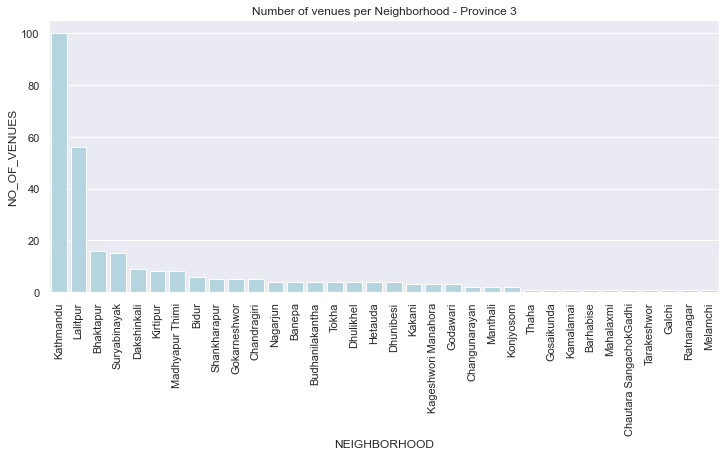

In [106]:
#Plot number of venues registered per neighborhood for PROVINCE 3
ax = sns.barplot(x='NEIGHBORHOOD',y='NO_OF_VENUES',data=venues_count.loc[venues_count.PROVINCE==3,:], color='lightblue')
ax.set_title('Number of venues per Neighborhood - Province 3')
ax.set_xticklabels(labels=venues_count.loc[venues_count.PROVINCE==3,:]['NEIGHBORHOOD'],rotation=90);

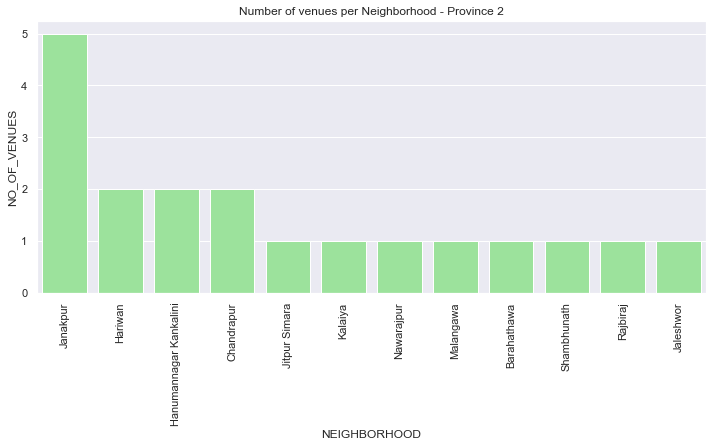

In [107]:
#Plot number of venues registered per neighborhood for PROVINCE 2
ax = sns.barplot(x='NEIGHBORHOOD',y='NO_OF_VENUES',data=venues_count.loc[venues_count.PROVINCE==2,:], color='lightgreen')
ax.set_title('Number of venues per Neighborhood - Province 2')
ax.set_xticklabels(labels=venues_count.loc[venues_count.PROVINCE==2,:]['NEIGHBORHOOD'],rotation=90);

In [108]:
#One hot encoding
venues_onehot = pd.get_dummies(venues.loc[:,'VENUE_CATEGORY'], prefix="", prefix_sep="")

In [109]:
venues_onehot.shape

(305, 95)

In [110]:
# Add the neighborhood column back to the dataframe
venues_onehot['NEIGHBORHOOD'] = venues['NEIGHBORHOOD']

In [111]:
venues_onehot.shape

(305, 96)

In [112]:
venues_onehot

,Airport,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Basketball Court,Bed & Breakfast,Beer Garden,Bistro,...,Steakhouse,Theme Park Ride / Attraction,Trail,Train Station,Tree,Vacation Rental,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Village,NEIGHBORHOOD
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Kamalamai
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Manthali
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Manthali
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Barhabise
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Chautara SangachokGadhi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Malangawa
301,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Chandrapur
302,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Chandrapur
303,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Jitpur Simara


In [113]:
# Average per neighborhood
venues_grouped = venues_onehot.groupby(['NEIGHBORHOOD']).mean().reset_index()
venues_grouped.head()

,NEIGHBORHOOD,Airport,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Basketball Court,Bed & Breakfast,Beer Garden,...,Spanish Restaurant,Steakhouse,Theme Park Ride / Attraction,Trail,Train Station,Tree,Vacation Rental,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Village
0,Banepa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0
1,Barahathawa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0
2,Barhabise,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0
3,Bhaktapur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0625,0.000000,0.0,0.0,0.0
4,Bidur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.166667,0.0,0.0,0.0


In [114]:
print(venues_grouped.shape)

(46, 96)


In [115]:
# Borrow the function from the lab. Sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [116]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['NEIGHBORHOOD']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create new dataframes
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)

neighborhoods_venues_sorted['NEIGHBORHOOD'] = venues_grouped['NEIGHBORHOOD']

for i in np.arange(neighborhoods_venues_sorted.shape[0]):
    neighborhoods_venues_sorted.iloc[i, 1:] = return_most_common_venues(venues_grouped.iloc[i, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,NEIGHBORHOOD,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Banepa,Café,Fast Food Restaurant,Bus Station,Village,Diner,Eastern European Restaurant,Farm,Fish & Chips Shop,Food,Forest
1,Barahathawa,Bus Stop,Village,Department Store,Dumpling Restaurant,Eastern European Restaurant,Farm,Fast Food Restaurant,Fish & Chips Shop,Food,Forest
2,Barhabise,River,Village,Department Store,Dumpling Restaurant,Eastern European Restaurant,Farm,Fast Food Restaurant,Fish & Chips Shop,Food,Forest
3,Bhaktapur,Hostel,Bus Station,Café,Plaza,Historic Site,Tree,Lake,Restaurant,Himalayan Restaurant,Indian Restaurant
4,Bidur,Indian Restaurant,Scenic Lookout,Vacation Rental,Restaurant,River,Village,Diner,Dumpling Restaurant,Eastern European Restaurant,Farm
5,Budhanilakantha,Resort,Athletics & Sports,Historic Site,Outdoors & Recreation,Village,French Restaurant,Dumpling Restaurant,Eastern European Restaurant,Farm,Fast Food Restaurant
6,Chandragiri,Coffee Shop,Record Shop,Historic Site,Park,French Restaurant,Dumpling Restaurant,Eastern European Restaurant,Farm,Fast Food Restaurant,Fish & Chips Shop
7,Chandrapur,Motel,Bus Station,Diner,Eastern European Restaurant,Farm,Fast Food Restaurant,Fish & Chips Shop,Food,Forest,French Restaurant
8,Changunarayan,Resort,Department Store,Diner,Dumpling Restaurant,Eastern European Restaurant,Farm,Fast Food Restaurant,Fish & Chips Shop,Food,Forest
9,Chautara SangachokGadhi,Soccer Field,Village,Garden,Dumpling Restaurant,Eastern European Restaurant,Farm,Fast Food Restaurant,Fish & Chips Shop,Food,Forest


In [117]:
#Add the basic neighborhood information
neighborhoods_venues_sorted = pd.merge(neighborhoods_venues_sorted, prov)
neighborhoods_venues_sorted.head(3)

,NEIGHBORHOOD,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,PROVINCE,DISTRICT,NEIGHBORHOOD_TYPE,LONGITUDE,LATITUDE
0,Banepa,Café,Fast Food Restaurant,Bus Station,Village,Diner,Eastern European Restaurant,Farm,Fish & Chips Shop,Food,Forest,3,KABHREPALANCHOK,Nagarpalika,85.515890,27.648074
1,Barahathawa,Bus Stop,Village,Department Store,Dumpling Restaurant,Eastern European Restaurant,Farm,Fast Food Restaurant,Fish & Chips Shop,Food,Forest,2,SARLAHI,Nagarpalika,85.456055,26.981470
2,Barhabise,River,Village,Department Store,Dumpling Restaurant,Eastern European Restaurant,Farm,Fast Food Restaurant,Fish & Chips Shop,Food,Forest,3,SINDHUPALCHOK,Nagarpalika,85.902438,27.821514


In [118]:
#Reorder columns
columns = ['PROVINCE','DISTRICT','NEIGHBORHOOD','LONGITUDE','LATITUDE'] + neighborhoods_venues_sorted.columns[1:11].tolist()
columns

['PROVINCE',
 'DISTRICT',
 'NEIGHBORHOOD',
 'LONGITUDE',
 'LATITUDE',
 '1st Most Common Venue',
 '2nd Most Common Venue',
 '3rd Most Common Venue',
 '4th Most Common Venue',
 '5th Most Common Venue',
 '6th Most Common Venue',
 '7th Most Common Venue',
 '8th Most Common Venue',
 '9th Most Common Venue',
 '10th Most Common Venue']

In [119]:
neighborhoods_venues_sorted = neighborhoods_venues_sorted.loc[:,columns]
neighborhoods_venues_sorted.head()

,PROVINCE,DISTRICT,NEIGHBORHOOD,LONGITUDE,LATITUDE,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,3,KABHREPALANCHOK,Banepa,85.515890,27.648074,Café,Fast Food Restaurant,Bus Station,Village,Diner,Eastern European Restaurant,Farm,Fish & Chips Shop,Food,Forest
1,2,SARLAHI,Barahathawa,85.456055,26.981470,Bus Stop,Village,Department Store,Dumpling Restaurant,Eastern European Restaurant,Farm,Fast Food Restaurant,Fish & Chips Shop,Food,Forest
2,3,SINDHUPALCHOK,Barhabise,85.902438,27.821514,River,Village,Department Store,Dumpling Restaurant,Eastern European Restaurant,Farm,Fast Food Restaurant,Fish & Chips Shop,Food,Forest
3,3,BHAKTAPUR,Bhaktapur,85.431881,27.674754,Hostel,Bus Station,Café,Plaza,Historic Site,Tree,Lake,Restaurant,Himalayan Restaurant,Indian Restaurant
4,3,NUWAKOT,Bidur,85.138304,27.925632,Indian Restaurant,Scenic Lookout,Vacation Rental,Restaurant,River,Village,Diner,Dumpling Restaurant,Eastern European Restaurant,Farm


## 3.3. Clustering Province 2 and Province 3 neighborhoods

In [120]:
# Import necessary libraries
import numpy as np 
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt 
from sklearn import preprocessing
%matplotlib inline

In [121]:
venues_grouped.head()

,NEIGHBORHOOD,Airport,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Basketball Court,Bed & Breakfast,Beer Garden,...,Spanish Restaurant,Steakhouse,Theme Park Ride / Attraction,Trail,Train Station,Tree,Vacation Rental,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Village
0,Banepa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0
1,Barahathawa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0
2,Barhabise,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0
3,Bhaktapur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0625,0.000000,0.0,0.0,0.0
4,Bidur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.166667,0.0,0.0,0.0


In [122]:
k_means = KMeans(init = "k-means++", n_clusters = 10, n_init = 500, max_iter=500)

In [123]:
# Fit the model 
k_means.fit(venues_grouped.drop('NEIGHBORHOOD',axis=1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=500,
       n_clusters=10, n_init=500, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [124]:
#Add the labels to the venues_grouped dataset
venues_grouped['CLUSTER']=k_means.labels_
venues_grouped.head()

,NEIGHBORHOOD,Airport,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Basketball Court,Bed & Breakfast,Beer Garden,...,Steakhouse,Theme Park Ride / Attraction,Trail,Train Station,Tree,Vacation Rental,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Village,CLUSTER
0,Banepa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,3
1,Barahathawa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,8
2,Barhabise,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,3
3,Bhaktapur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0625,0.000000,0.0,0.0,0.0,3
4,Bidur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.166667,0.0,0.0,0.0,3


In [125]:
neighborhoods_venues_sorted = pd.merge(neighborhoods_venues_sorted, venues_grouped)
neighborhoods_venues_sorted.head(3)

,PROVINCE,DISTRICT,NEIGHBORHOOD,LONGITUDE,LATITUDE,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,...,Steakhouse,Theme Park Ride / Attraction,Trail,Train Station,Tree,Vacation Rental,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Village,CLUSTER
0,3,KABHREPALANCHOK,Banepa,85.515890,27.648074,Café,Fast Food Restaurant,Bus Station,Village,Diner,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,2,SARLAHI,Barahathawa,85.456055,26.981470,Bus Stop,Village,Department Store,Dumpling Restaurant,Eastern European Restaurant,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
2,3,SINDHUPALCHOK,Barhabise,85.902438,27.821514,River,Village,Department Store,Dumpling Restaurant,Eastern European Restaurant,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


Now, our customer wishes to open the restaurant in a neighborhood similar to Kathmadu. Lets check on which cluster does that neighborhood belong to

In [126]:
neighborhoods_venues_sorted.groupby('CLUSTER').count().NEIGHBORHOOD

CLUSTER
0     3
1     8
2     3
3    24
4     2
5     1
6     1
7     1
8     2
9     1
Name: NEIGHBORHOOD, dtype: int64

In [215]:
target_cluster_df = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['NEIGHBORHOOD']=='Kathmandu',:]
target_cluster_df.reset_index(inplace=True, drop=True)
target_cluster = target_cluster_df.loc[0,'CLUSTER']
print('The target cluster is: {} '.format(target_cluster))
target_cluster_df.head()

The target cluster is: 3 


,PROVINCE,DISTRICT,NEIGHBORHOOD,LONGITUDE,LATITUDE,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,...,Steakhouse,Theme Park Ride / Attraction,Trail,Train Station,Tree,Vacation Rental,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Village,CLUSTER
0,3,KATHMANDU,Kathmandu,85.329528,27.708764,Asian Restaurant,Restaurant,Hotel,Coffee Shop,Café,...,0.01,0.01,0.0,0.0,0.0,0.0,0.01,0.01,0.0,3


In [216]:
#Filter neighborhoods from Province 2 that belong to the target cluster
possible_neighborhoods = neighborhoods_venues_sorted[
    (neighborhoods_venues_sorted['CLUSTER']==target_cluster) &
    (neighborhoods_venues_sorted['PROVINCE']==2)]

print('There are {} neighborhoods in Province 2 with similar characteristics to Kathmandu'
      .format(possible_neighborhoods.shape[0]))

There are 5 neighborhoods in Province 2 with similar characteristics to Kathmandu


In [217]:
# Clean up index
possible_neighborhoods.reset_index(inplace=True, drop=True)

In [218]:
# Print the possible neighborhoods
possible_neighborhoods = possible_neighborhoods.loc[:,['DISTRICT','NEIGHBORHOOD','1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue']]
possible_neighborhoods

,DISTRICT,NEIGHBORHOOD,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,SAPTARI,Hanumannagar Kankalini,Pool,Clothing Store,Village
1,SARLAHI,Hariwan,Coffee Shop,Fast Food Restaurant,Village
2,DHANUSHA,Janakpur,Hotel,Train Station,Bed & Breakfast
3,BARA,Jitpur Simara,Moving Target,Village,Hotel
4,SIRAHA,Nawarajpur,Harbor / Marina,Village,Garden


### 3.4. Neighborhood Ranking

We now have a dataset containing a list of potential neighborhoods. Let us also find the most suitable among them

We will rank each neighborhood based on a composite ranking using the following items:

a. Total Population. Weight: 50%  
b. Average income per household within each neighborhood. Weight: 35%  
c. Amount of already existing Hotel. Weight: 15%

To create this ranking, lets first normalize each of the three metrics

In [219]:
#we have
prov2_cord_popu_income.head()

,PROVINCE,DISTRICT,NEIGHBORHOOD_TYPE,NEIGHBORHOOD,LONGITUDE,LATITUDE,POPULATION,PER CAPITA INCOME (USD),POPULATION_NORMALIZED,INCOME_NORMALIZED
0,2,SAPTARI,Gaunpalika,Agnisair Krishna Savaran,86.796975,26.646790,27129,801.0,0.111145,0.541216
1,2,SAPTARI,Gaunpalika,Balan Bihul,86.522056,26.571204,21842,801.0,0.089485,0.541216
2,2,SAPTARI,Gaunpalika,Bishnupur_saptari,86.720324,26.518306,23166,801.0,0.094909,0.541216
3,2,SAPTARI,Nagarpalika,Bode Barsain,86.573847,26.564128,43293,801.0,0.177368,0.541216
4,2,SAPTARI,Gaunpalika,Chhinnamasta,86.734078,26.461687,28437,801.0,0.116504,0.541216


In [220]:
max_popu = prov2_cord_popu_income['POPULATION'].max(axis=0)
max_income = prov2_cord_popu_income['PER CAPITA INCOME (USD)'].max(axis=0)

In [221]:
prov2_cord_popu_income['POPULATION_NORMALIZED'] = prov2_cord_popu_income['POPULATION']/max_popu
prov2_cord_popu_income['INCOME_NORMALIZED'] = prov2_cord_popu_income['PER CAPITA INCOME (USD)']/max_income
prov2_cord_popu_income.head(3)

,PROVINCE,DISTRICT,NEIGHBORHOOD_TYPE,NEIGHBORHOOD,LONGITUDE,LATITUDE,POPULATION,PER CAPITA INCOME (USD),POPULATION_NORMALIZED,INCOME_NORMALIZED
0,2,SAPTARI,Gaunpalika,Agnisair Krishna Savaran,86.796975,26.646790,27129,801.0,0.111145,0.541216
1,2,SAPTARI,Gaunpalika,Balan Bihul,86.522056,26.571204,21842,801.0,0.089485,0.541216
2,2,SAPTARI,Gaunpalika,Bishnupur_saptari,86.720324,26.518306,23166,801.0,0.094909,0.541216


In [222]:
venues_grouped.columns

Index(['NEIGHBORHOOD', 'Airport', 'Asian Restaurant', 'Athletics & Sports',
       'BBQ Joint', 'Bakery', 'Bar', 'Basketball Court', 'Bed & Breakfast',
       'Beer Garden', 'Bistro', 'Breakfast Spot', 'Buddhist Temple',
       'Burger Joint', 'Bus Station', 'Bus Stop', 'Business Service', 'Café',
       'Campground', 'Chinese Restaurant', 'City', 'Clothing Store',
       'Coffee Shop', 'Cuban Restaurant', 'Department Store', 'Diner',
       'Dumpling Restaurant', 'Eastern European Restaurant', 'Farm',
       'Fast Food Restaurant', 'Fish & Chips Shop', 'Food', 'Forest',
       'French Restaurant', 'Fried Chicken Joint', 'Garden', 'Gastropub',
       'German Restaurant', 'Golf Course', 'Gym', 'Halal Restaurant',
       'Harbor / Marina', 'Himalayan Restaurant', 'Historic Site',
       'History Museum', 'Hookah Bar', 'Hostel', 'Hotel', 'Hotel Bar',
       'Ice Cream Shop', 'Indian Restaurant', 'Intersection',
       'Italian Restaurant', 'Japanese Restaurant', 'Lake', 'Laser Tag',
     

In [223]:
neighborhoods_venues_sorted.head()

,PROVINCE,DISTRICT,NEIGHBORHOOD,LONGITUDE,LATITUDE,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,...,Steakhouse,Theme Park Ride / Attraction,Trail,Train Station,Tree,Vacation Rental,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Village,CLUSTER
0,3,KABHREPALANCHOK,Banepa,85.515890,27.648074,Café,Fast Food Restaurant,Bus Station,Village,Diner,...,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,3
1,2,SARLAHI,Barahathawa,85.456055,26.981470,Bus Stop,Village,Department Store,Dumpling Restaurant,Eastern European Restaurant,...,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,8
2,3,SINDHUPALCHOK,Barhabise,85.902438,27.821514,River,Village,Department Store,Dumpling Restaurant,Eastern European Restaurant,...,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,3
3,3,BHAKTAPUR,Bhaktapur,85.431881,27.674754,Hostel,Bus Station,Café,Plaza,Historic Site,...,0.0,0.0,0.0,0.0,0.0625,0.000000,0.0,0.0,0.0,3
4,3,NUWAKOT,Bidur,85.138304,27.925632,Indian Restaurant,Scenic Lookout,Vacation Rental,Restaurant,River,...,0.0,0.0,0.0,0.0,0.0000,0.166667,0.0,0.0,0.0,3


In [224]:
#Based on section 3.2 
prov2_hotel = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted.PROVINCE==2, :].reset_index(drop=True)
prov2_hotel.head()

,PROVINCE,DISTRICT,NEIGHBORHOOD,LONGITUDE,LATITUDE,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,...,Steakhouse,Theme Park Ride / Attraction,Trail,Train Station,Tree,Vacation Rental,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Village,CLUSTER
0,2,SARLAHI,Barahathawa,85.456055,26.981470,Bus Stop,Village,Department Store,Dumpling Restaurant,Eastern European Restaurant,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
1,2,RAUTAHAT,Chandrapur,85.370446,27.138608,Motel,Bus Station,Diner,Eastern European Restaurant,Farm,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,2,SAPTARI,Hanumannagar Kankalini,86.878736,26.512161,Pool,Clothing Store,Village,Dumpling Restaurant,Eastern European Restaurant,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,2,SARLAHI,Hariwan,85.576516,27.100324,Coffee Shop,Fast Food Restaurant,Village,Department Store,Dumpling Restaurant,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,2,MAHOTTARI,Jaleshwor,85.801918,26.646348,Bus Stop,Village,Department Store,Dumpling Restaurant,Eastern European Restaurant,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8


In [225]:
prov2_hotel = prov2_hotel.loc[:, ['NEIGHBORHOOD','Hotel']]
prov2_hotel.rename(columns={"Hotel": "NUMBER OF HOTELS"}, inplace=True)
prov2_hotel.head()

,NEIGHBORHOOD,NUMBER OF HOTELS
0,Barahathawa,0.0
1,Chandrapur,0.0
2,Hanumannagar Kankalini,0.0
3,Hariwan,0.0
4,Jaleshwor,0.0


In [226]:
#"Normalize" and invert. This way, if a row is 1 then it means there are no hotels
prov2_hotel['BAR NUMBER OF HOTELS'] = 1-(prov2_hotel.loc[:,'NUMBER OF HOTELS']/prov2_hotel['NUMBER OF HOTELS'].max(axis=0))
prov2_hotel.head(10)

,NEIGHBORHOOD,NUMBER OF HOTELS,BAR NUMBER OF HOTELS
0,Barahathawa,0.0,1.0
1,Chandrapur,0.0,1.0
2,Hanumannagar Kankalini,0.0,1.0
3,Hariwan,0.0,1.0
4,Jaleshwor,0.0,1.0
5,Janakpur,0.4,0.6
6,Jitpur Simara,0.0,1.0
7,Kalaiya,0.0,1.0
8,Malangawa,0.0,1.0
9,Nawarajpur,0.0,1.0


In [227]:
possible_neighborhoods = pd.merge(possible_neighborhoods.loc[:,['DISTRICT','NEIGHBORHOOD']],prov2_cord_popu_income)
possible_neighborhoods = pd.merge(possible_neighborhoods,prov2_hotel)
possible_neighborhoods.head()

,DISTRICT,NEIGHBORHOOD,PROVINCE,NEIGHBORHOOD_TYPE,LONGITUDE,LATITUDE,POPULATION,PER CAPITA INCOME (USD),POPULATION_NORMALIZED,INCOME_NORMALIZED,NUMBER OF HOTELS,BAR NUMBER OF HOTELS
0,SAPTARI,Hanumannagar Kankalini,2,Nagarpalika,86.878736,26.512161,45840,801.0,0.187803,0.541216,0.0,1.0
1,SARLAHI,Hariwan,2,Nagarpalika,85.576516,27.100324,43924,809.0,0.179953,0.546622,0.0,1.0
2,DHANUSHA,Janakpur,2,Upamahanagarpalika,85.936686,26.725416,162842,938.0,0.667150,0.633784,0.4,0.6
3,BARA,Jitpur Simara,2,Upamahanagarpalika,85.010673,27.200295,118398,1480.0,0.485067,1.000000,0.0,1.0
4,SIRAHA,Nawarajpur,2,Gaunpalika,86.435139,26.607590,19056,689.0,0.078071,0.465541,0.0,1.0


In [228]:
possible_neighborhoods.shape

(5, 12)

In [229]:
possible_neighborhoods['RANKING'] = possible_neighborhoods['POPULATION_NORMALIZED'] * 0.5 + possible_neighborhoods['INCOME_NORMALIZED'] * 0.35 + possible_neighborhoods['BAR NUMBER OF HOTELS'] * 0.15
recommended_neighborhoods = possible_neighborhoods.sort_values(by='RANKING',ascending=False)
recommended_neighborhoods.reset_index(inplace=True, drop=True)

In [230]:
recommended_neighborhoods = recommended_neighborhoods.loc[:,['DISTRICT','NEIGHBORHOOD','RANKING', 'LONGITUDE', 'LATITUDE']]

In [231]:
recommended_neighborhoods.head()

,DISTRICT,NEIGHBORHOOD,RANKING,LONGITUDE,LATITUDE
0,BARA,Jitpur Simara,0.742533,85.010673,27.200295
1,DHANUSHA,Janakpur,0.645399,85.936686,26.725416
2,SAPTARI,Hanumannagar Kankalini,0.433327,86.878736,26.512161
3,SARLAHI,Hariwan,0.431294,85.576516,27.100324
4,SIRAHA,Nawarajpur,0.351975,86.435139,26.607590
